In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import pandas as pd
from tqdm import tqdm, trange
from torchvision.transforms import Compose, Resize, Normalize, CenterCrop
# from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import copy
# from new_dataset import CocoDataset

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_properties(device = 'cuda:0'))

True
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4095MB, multi_processor_count=6)


In [5]:
image_captions_df = pd.read_parquet('F://coco/captions/image_captions_df_less_than_15.parquet')
image_captions_df

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9
2,222016,COCO_train2014_000000222016.jpg,"[[a, big, red, telephone, booth, that, a, man,...","[inside, person, image, standing, is, an, that...","[[27, 66, 62, 67, 65, 61, 27, 53, 1, 59, 29], ...","[[a, big, red, telephone, booth, that, a, man,...","[a, man, using, a, phone, in, a, phone, booth, .]",10
3,520950,COCO_train2014_000000520950.jpg,"[[the, kitchen, is, full, of, spices, on, the,...","[is, on, that, kitchen, all, utilizes, with, i...","[[20, 35, 1, 73, 28, 80, 3, 20, 75], [27, 35, ...","[[the, kitchen, is, full, of, spices, on, the,...","[a, very, small, kitchen, with, a, stove, and,...",12
4,69675,COCO_train2014_000000069675.jpg,"[[a, child, and, woman, are, cooking, in, the,...","[child, woman, person, on, women, an, together...","[[27, 88, 12, 89, 94, 98, 29, 20, 99], [27, 89...","[[a, child, and, woman, are, cooking, in, the,...","[two, women, cooking, on, stove, in, a, kitche...",10
...,...,...,...,...,...,...,...,...
66657,53136,COCO_train2014_000000053136.jpg,"[[vegetable, and, rice, dish, served, in, a, w...","[bed, vegetables, on, white, top, with, pasta,...","[[2753, 12, 2778, 339, 995, 29, 27, 118, 358],...","[[vegetable, and, rice, dish, served, in, a, w...","[a, white, bowl, contains, shredded, cabbage, ...",9
66658,360271,COCO_train2014_000000360271.jpg,"[[women, sitting, at, a, dinner, table, with, ...","[woman, another, dinner., sitting, is, watchin...","[[90, 215, 102, 27, 311, 4, 7, 140, 145, 102, ...","[[women, sitting, at, a, dinner, table, with, ...","[a, bunch, of, women, are, eating, at, a, table]",9
66660,444010,COCO_train2014_000000444010.jpg,"[[a, group, of, friends, sitting, down, at, a,...","[woman, jovial, sitting, table, group, togethe...","[[27, 362, 28, 2829, 215, 144, 102, 27, 4, 330...","[[a, group, of, friends, sitting, down, at, a,...","[a, jovial, older, couple, and, a, young, woma...",14
66661,565004,COCO_train2014_000000565004.jpg,"[[wine, being, poured, into, a, glass, over, a...","[another, is, on, table, wine, with, red, glas...","[[418, 319, 6776, 161, 27, 686, 139, 27, 4], [...","[[wine, being, poured, into, a, glass, over, a...","[a, wine, glass, being, filled, with, red, win...",9


In [6]:
with open('F:/coco/annotations/instances_train2014.json') as file:
    data = file.read()
    data = json.loads(data)

In [7]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [8]:
category_df = pd.DataFrame.from_records(data['categories'])
# category_df[category_df['id']==55]
category_df

,supercategory,id,name
0,person,1,person
1,vehicle,2,bicycle
2,vehicle,3,car
3,vehicle,4,motorcycle
4,vehicle,5,airplane
...,...,...,...
75,indoor,86,vase
76,indoor,87,scissors
77,indoor,88,teddy bear
78,indoor,89,hair drier


In [9]:
enum_super_categories = list(category_df['supercategory'].unique())
enum_super_categories

['person',
 'vehicle',
 'outdoor',
 'animal',
 'accessory',
 'sports',
 'kitchen',
 'food',
 'furniture',
 'electronic',
 'appliance',
 'indoor']

In [10]:
data_df = pd.DataFrame.from_records(data['annotations'])
data_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[312.29, 562.89, 402.25, 511.49, 400.96, 425....",54652.95560,0,480023,"[116.95, 305.86, 285.3, 266.03]",58,86
1,"[[252.46, 208.17, 267.96, 210.11, 280.14, 213....",421.47275,0,50518,"[245.54, 208.17, 40.14, 19.1]",58,89


In [11]:

data_df['category_name'] = data_df['category_id'].map(category_df.set_index('id')['name'])
data_df['super_category'] = data_df['category_id'].map(category_df.set_index('id')['supercategory'])
data_df['super_category_id'] = data_df['super_category'].apply(lambda x: enum_super_categories.index(x))
data_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id,category_name,super_category,super_category_id
0,"[[312.29, 562.89, 402.25, 511.49, 400.96, 425....",54652.95560,0,480023,"[116.95, 305.86, 285.3, 266.03]",58,86,hot dog,food,7
1,"[[252.46, 208.17, 267.96, 210.11, 280.14, 213....",421.47275,0,50518,"[245.54, 208.17, 40.14, 19.1]",58,89,hot dog,food,7


In [12]:
new_data_df = data_df.groupby(['image_id']).agg(list)
new_data_df.head(2)

,segmentation,area,iscrowd,bbox,category_id,id,category_name,super_category,super_category_id
image_id,,,,,,,,,
9,"[[[500.49, 473.53, 599.73, 419.6, 612.67, 375....","[120057.13925, 44434.751099999994, 49577.94434...","[0, 0, 0, 0, 0, 0, 0, 0]","[[1.08, 187.69, 611.59, 285.84], [311.73, 4.31...","[51, 51, 56, 51, 55, 55, 55, 55]","[1038967, 1039564, 1058555, 1534147, 1913551, ...","[bowl, bowl, broccoli, bowl, orange, orange, o...","[kitchen, kitchen, food, kitchen, food, food, ...","[6, 6, 7, 6, 7, 7, 7, 7]"
25,"[[[437.52, 353.33, 437.87, 326.98, 433.65, 306...","[19686.597949999996, 2785.8475500000004]","[0, 0]","[[385.53, 60.03, 214.97, 297.16], [53.01, 356....","[25, 25]","[598548, 599491]","[giraffe, giraffe]","[animal, animal]","[3, 3]"


In [13]:
new_captions_df = pd.merge(left = image_captions_df, right = new_data_df, how='inner', on='image_id')
new_captions_df.head(2)

,image_id,file_name,captions,caption_token_set,idx_captions,tokens,shortest_token,shortest_token_len,segmentation,area,iscrowd,bbox,category_id,id,category_name,super_category,super_category_id
0,57870,COCO_train2014_000000057870.jpg,"[[a, restaurant, has, modern, wooden, tables, ...","[arrangement, is, flower, on, table, blue, top...","[[27, 13, 25, 23, 9, 30, 12, 19], [27, 22, 13,...","[[a, restaurant, has, modern, wooden, tables, ...","[a, table, is, adorned, with, wooden, chairs, ...",11,"[[[233.29, 461.42, 235.35, 395.35, 240.52, 378...","[21635.5728, 15217.232600000001, 9265.96560000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[233.29, 270.45, 170.32, 203.36], [1.02, 279....","[62, 67, 62, 62, 62, 62, 62, 62, 62, 86, 62, 6...","[102924, 118582, 290250, 290659, 290682, 29071...","[chair, dining table, chair, chair, chair, cha...","[furniture, furniture, furniture, furniture, f...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 11, 8, 8, 8, 8, 11..."
1,384029,COCO_train2014_000000384029.jpg,"[[a, man, preparing, desserts, in, a, kitchen,...","[types, desserts, person, is, kitchen, many, u...","[[27, 53, 56, 33, 29, 27, 35, 42, 29, 50], [27...","[[a, man, preparing, desserts, in, a, kitchen,...","[close, up, of, a, hand, touching, various, pa...",9,"[[[215.95, 293.07, 182.2, 241.01, 182.2, 209.2...","[87957.80790000001, 11719.74135, 8757.37445, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[4.82, 2.89, 478.17, 302.71], [312.35, 229.44...","[1, 61, 61, 60, 60, 60, 60, 61, 61, 61, 61, 61...","[423921, 1086559, 1577025, 1925582, 1926447, 1...","[person, cake, cake, donut, donut, donut, donu...","[person, food, food, food, food, food, food, f...","[0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]"


In [19]:
manual_transforms = Compose([
                            Resize(size = (448,448), antialias = True),
                            # CenterCrop(size=(448,448)),
#                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [20]:
class CocoDataset(Dataset):
    def __init__(self,data_df, is_train=False, is_val=False, is_test = False, val_percent=10, test_percent = 5, transforms = None):
        self.new_data_df = copy.deepcopy(data_df)
        self.transforms = transforms
        
        
        
        if is_val:
            self.data_df = self.new_data_df.sample(frac = float(val_percent/100), axis = 0, ignore_index = True)
        if is_test:
            self.data_df = self.new_data_df.sample(frac = float(test_percent/100), axis = 0, ignore_index = True)
        else:
            self.data_df = self.new_data_df.sample(frac = 1- (float(val_percent/100) + float(test_percent/100)), axis = 0, ignore_index = True)
            
    def __len__(self):
        return len(self.data_df)
    
    def transform_bbox(self,bboxes, spatial_size, final_size):
        width, height = spatial_size[0], spatial_size[1]
        # new_bbox = torch.zeros_like(bboxes)
        bboxes[...,0] = (bboxes[...,0]/spatial_size[1])*final_size[0]
        bboxes[...,1] = (bboxes[...,1]/spatial_size[0])*final_size[1]
        bboxes[...,2] = bboxes[...,2]*(final_size[1]/spatial_size[1])
        bboxes[...,3] = bboxes[...,3]*(final_size[0]/spatial_size[0])

        return bboxes
    
    def make_target_tensor(self,bboxes):
        target_tensor = torch.zeros(7,7,17)
        for box in bboxes:
            x_cell, y_cell = int(box[1]/64), int(box[2]/64)
    
            if target_tensor[x_cell][y_cell].sum() ==0:              
                box[...,1:5] = box[...,1:5]/448.0
                target_tensor[x_cell][y_cell] = box
                
        return target_tensor
    
    def __getitem__(self, ndx):
        folder_path = 'F://coco/train2014/train2014/'
        
        row = self.data_df.iloc[ndx]
        file_name = row['file_name']
        bboxes = torch.tensor(row['bbox'])
        cat_id = torch.tensor(row['super_category_id'])
        cat_names = row['super_category']
        image_id = row['image_id']        
        
        # Get the image-data from file_name
        image_array = torchvision.io.read_image(folder_path + file_name)
        image_array = (image_array/255.0).to(torch.float32)
        

        if self.transforms != None: # If transfroms are specified then convert the image and the bounding box to correct_size
            # Get the initial_size of the image
            spatial_size = image_array.shape[1:]

            # Transform the image
            image_array = self.transforms(image_array).to(torch.float32)
            # Convert the image and the bounding boxes to their specific sizes
            final_size = image_array.shape[1:]

            # Now we will input the bboxes, initial_imgage_size and the final_image_size to convert the bounding boxes.
            bboxes = self.transform_bbox(bboxes, spatial_size=spatial_size, final_size=final_size)       
        

        # Convert the bounding boxes to the dimension format understoood by the image.
        bboxes = torchvision.ops.box_convert(bboxes, in_fmt='xywh', out_fmt='xyxy')

        # After transforming the image we convert the individual bounding boxes, classes and confidence of object to target tensor
        # The format of the out tensor is [object_confidence, bounding_boxes, one-hot class labels]
        y = torch.full((len(bboxes),1), fill_value = 1)
        new = torch.cat((y,bboxes), axis = 1)
        x = F.one_hot(cat_id, num_classes = 12)
        out = torch.cat((new,x ), axis = 1)
        
        target_tensor = self.make_target_tensor(out)
        assert target_tensor.shape == (7,7,17)
        
        
        return image_array,target_tensor
        
    def get_data_image_id(self,image_id=None):
        """ This function returns an image by its id and the corresponding multiple labesl in a present/no_present binary format"""
        

        folder_path = 'F://coco/train2014/train2014/'

        if image_id == None:
            raise ValueError('Must provide IMAGE ID')
        
        else:
            row = self.data_df[self.data_df['image_id']==image_id]
            file_name = row['file_name'].values[0]
            bounding_boxes_list = row['bbox'].values[0]
            category_id_list = row['category_id'].values[0]
            category_names_list = row['category_name'].values[0]

#             captions_array = torch.tensor(row['shortest_idx_tokens'][0][0])

            # Get the image-data from file_name
            image_array = torchvision.io.read_image(folder_path + file_name)
            image_array = (image_array/255.0).to(torch.float64)
            if self.transforms != None:
                image_array = self.transforms(image_array).to(torch.float32)
                
            # After transforming the image now we set up the target tensor that will be outputted
            # After transforming the image now we set up the target tensor that will be outputted
            y = torch.full((len(category_id_list),1), fill_value = 1)
            new = torch.cat((y,bounding_boxes_list), axis = 1)
            x = F.one_hot(category_id_list, num_classes = 12)
            out = torch.cat((new,x), axis = 1)
            return image_array, out, category_names_list
        
            

In [21]:
test_coco = CocoDataset(data_df=new_captions_df,is_test = True, transforms=manual_transforms, test_percent=0.8)
# val_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms)
# train_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms)

test_coco_dataloader = DataLoader(dataset=test_coco,shuffle=True, pin_memory=True,batch_size = 4)
# val_coco_dataloader = DataLoader(dataset=val_coco,shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)
# train_coco_dataloader = DataLoader(dataset = train_coco, shuffle = True, pin_memory=True,num_workers=2,batch_size = 1)

In [30]:
len(test_coco_dataloader)

502

In [53]:
x = torch.tensor([1,2,3,4])
p, y = torch.max(x, dim=0)
print(p,y)

tensor(4) tensor(3)


torch.Size([3, 448, 448]) torch.Size([7, 7, 17])


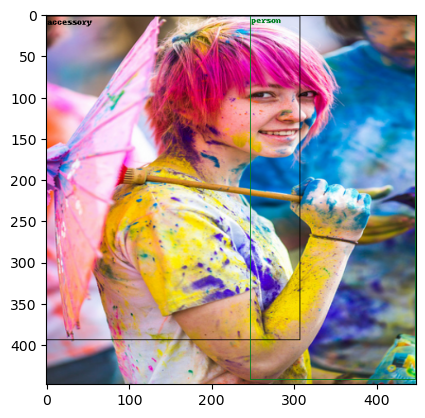

In [63]:
image,targets = test_coco[7]
print(image.shape, targets.shape)

objects_list = []
class_names_list = []
for target in targets:
    for box in target:
        if box.sum().item() == 0:
            continue
        else:
            objects_list.append(box)
            
            values, indices = torch.max(box[5:], dim=0)
            class_names_list.append(enum_super_categories[indices.item()])

object_tensor = torch.stack(objects_list)            
plot_image = torchvision.utils.draw_bounding_boxes((image*255).to(torch.uint8), object_tensor[:,1:5]*448.0, labels=class_names_list)
ax = plt.imshow(plot_image.permute(1,2,0).numpy())
            


In [56]:
print(objects_list)
print(class_names_list)

[tensor([1.0000, 0.0000, 0.0060, 0.6856, 0.8804, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([1.0000e+00, 5.5326e-01, 2.1875e-04, 1.0000e+00, 9.8680e-01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])]
[4, 0]


c:\Users\Anant\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


['sports', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']
torch.Size([3, 448, 448])
torch.Size([11, 17])
tensor([[1.0000e+00, 3.7949e-01, 3.9550e-01, 6.0768e-01, 5.9776e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.3488e-02, 1.2600e-01, 4.7603e-01, 8.9052e-01, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.1492e-01, 1.1786e-01, 4.6055e-01, 2.8688e-01, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.5210e-01, 3.5020e-02, 9.9989e-01, 7.7900e-01, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

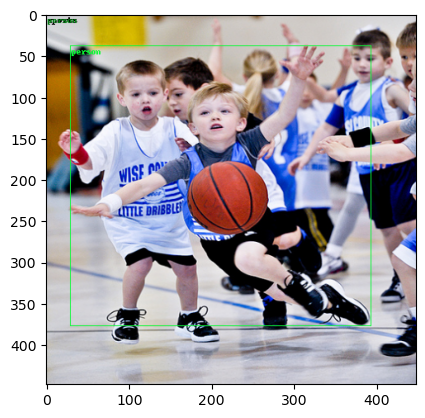

In [31]:
image,out, target_tensor, cat_name, image_id = test_coco[55]
print(cat_name)
# print(out.shape)
# print(image.shape)
# plt.imshow(image.permute(1,2,0).numpy())
# print(out)
# print(out.shape, len(cat_name), cat_name)
print(image.shape)
print(out.shape)
print(out)

print(image_id)
print(out[:,1:5].shape)
# box1 = torchvision.ops.box_convert(out[:,1:5], in_fmt='xywh', out_fmt='xyxy')
# print(box1)
plot_image = torchvision.utils.draw_bounding_boxes((image*255).to(torch.uint8), out[:,1:5], labels=cat_name)
ax = plt.imshow(plot_image.permute(1,2,0).numpy())

In [35]:
class YoloBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=1, bias = False)
        self.batchnorm1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size = 3, padding = 1, bias = False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.batchnorm1(out))

        out = self.conv2(x)
        out = F.relu(self.batchnorm2(out))
        return out

In [36]:
class Yolo(nn.Module):
    def __init__(self):

        super(Yolo,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3,padding=1,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1,bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1,bias=False)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1,bias=False)
        self.batchnorm6 = nn.BatchNorm2d(512)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv7 = nn.Sequential(YoloBlock(256,512),
                                   YoloBlock(256,512),
                                   YoloBlock(256,512),
                                   YoloBlock(256,512))
        
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1,bias=False)
        self.batchnorm8 = nn.BatchNorm2d(512)
        
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1,bias=False)
        self.batchnorm9 = nn.BatchNorm2d(1024)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv10 = nn.Sequential(YoloBlock(512,1024),
                                    YoloBlock(512,1024),)
        
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=3, padding=1,bias=False)
        self.batchnorm11 = nn.BatchNorm2d(1024)
        
        self.conv12 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, stride=2, padding=1,bias=False)
        self.batchnorm12 = nn.BatchNorm2d(1024)
        
        self.conv13 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1,bias=False)
        self.batchnorm13 = nn.BatchNorm2d(1024)
        
        self.conv14 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1,bias=False)
        self.batchnorm14 = nn.BatchNorm2d(1024)

        self.linear1 = nn.Linear(in_features=1024, out_features=4096,bias=False)
        self.batchnorm15 = nn.BatchNorm1d(4096)
        
        self.linear2 = nn.Linear(in_features=4096, out_features=34)
    def forward(self, x):
        out = F.relu(self.batchnorm1(self.conv1(x)))
        out = self.maxpool1(out)
        
        out = F.relu(self.batchnorm2(self.conv2(out)))
        out = self.maxpool2(out)
        
        out = F.relu(self.batchnorm3(self.conv3(out)))
        out = F.relu(self.batchnorm4(self.conv4(out)))
        out = F.relu(self.batchnorm5(self.conv5(out)))
        
        out = F.relu(self.batchnorm6(self.conv6(out)))
        out = self.maxpool3(out)
#         print(out.shape)
        out = self.conv7(out)
#         print(out.shape)
        out = F.relu(self.batchnorm8(self.conv8(out)))
        out = F.relu(self.batchnorm9(self.conv9(out)))
        out = self.maxpool4(out)
#         print(out.shape)
        out = self.conv10(out)
    
        out = F.relu(self.batchnorm11(self.conv11(out)))
        out = F.relu(self.batchnorm12(self.conv12(out)))
        out = F.relu(self.batchnorm13(self.conv13(out)))
        out = F.relu(self.batchnorm14(self.conv14(out)))
        # print(out.shape)
        out = out.reshape(-1,1024)
        # print(out.shape)
        out = F.relu(self.batchnorm15(self.linear1(out)))
        out = self.linear2(out)
        # print(out.shape)
        out = out.reshape(7,7,-1)
        return out

In [37]:
def loss_fn(preds, targets):
    # The loss fn will be divided into 4 parts
    # 1. Calculate the confidence scores i.e (Is the object present*IOU)
    # 2. Calculate the box_loss
    # 3. Calculate he object and no_object_loss
    # 4. Calculate the class probabilities.
    # We get preds and the targets as 7,7,34 and 7,7,17 tensors respectively
    # We will calculate the individual losses of the cells and then sum them up to form the whole image loss
    # We will start with getting the box1 and box2 of the predictions
    # First we will calculate the best box (box with highest IOU with the target boxes)
    box_1_iou = torchvision.ops.box_iou(boxes1=preds[...,1:5].reshape(-1,4), boxes2 = targets[...,1:5].reshape(-1,4))
    print(box_1_iou.shape)
    box_2_iou = torchvision.ops.box_iou(boxes1=preds[...,18:22].reshape(-1,4), boxes2 = targets[...,1:5].reshape(-1,4))
    print(box_2_iou.shape)

    box_1_iou = torch.diagonal(box_1_iou) # This would be the iou of boxes like : iou of 1st box in pred_box1 with 1st box in targets
    box_2_iou = torch.diagonal(box_2_iou) # This would be the iou of boxes like : iou of 1st box in pred_box2 with 1st box in targets
    print(box_1_iou.shape)
    print(box_2_iou.shape)
    
    # box_dict = {0:pred_box1, 1:pred_box2}
    # next we will calculate the max_iou between the first box and the second box to calculate the best_box_iou for each cell
    max_iou_tensor = torch.column_stack([box_1_iou, box_2_iou])
    print(max_iou_tensor.shape)

    indices, values = torch.max(max_iou_tensor, 1)
    indices = indices.to(torch.int64)
    values = values.reshape(7,7)
    

    # Now lets concatenate both the bounding boxes tensors column-wise and reshape them 
    bbox_tensor = preds.reshape(-1,2,17)
    assert bbox_tensor.shape == (49,2,17)

    

    # Then lets find the best box which has the highest IOU with the target box for each of the pairs of boxes
    best_box_tensor = bbox_tensor[torch.arange(bbox_tensor.shape[0]), indices].reshape(7,7,-1)
    print(best_box_tensor.shape)
    print(values)
    print(values.shape)
    print(target_tensor[...,0],target_tensor[...,0].shape)

    

    # Now we have the best box for each cell which then we can compare with out target tensor and calculate our losses
    # The next step is to calculate the loss

    # We will start with the confidence loss
    # confidence_loss is the product of P(o)*IOU. So if an object is there then this loss is like the IOU else it is zero
    # Confidence_loss if the object is present
    confidence_obj_tensor = best_box_tensor[...,0]*values
    print(confidence_obj_tensor.shape)
    confidence_no_obj_tensor = (1-confidence_obj_tensor)
    print(confidence_no_obj_tensor.shape)
    # confidence_loss when object is present or not present
    confidence_obj_loss = F.mse_loss(confidence_obj_tensor, target_tensor[...,0])
    confidence_no_obj_loss = F.mse_loss(confidence_no_obj_tensor,target_tensor[...,0])

    # Then find the total_obj_and_no_obj loss giving weightage to no_obj_loss
    total_confidence_loss = confidence_obj_loss + (0.5*confidence_no_obj_loss)

    # Next we would find the coordinate losses
    best_box_pred = best_box_tensor[...,0].reshape(7,7,-1)*best_box_tensor[...,1:5]
    print(best_box_pred.shape)
    target_box = target_tensor[...,1:5]
    print(target_box.shape)

    # print(best_box_pred.shape, target_box.shape)

    x1_y1_coord_loss =  F.mse_loss(best_box_pred[...,1:3], target_box[...,1:3])
    x2_y2_coord_loss =  F.mse_loss(best_box_pred[...,3:5], target_box[...,3:5])

    # print(x1_y1_coord_loss)
    total_coord_loss = 5*x1_y1_coord_loss + 5*x2_y2_coord_loss

    # Next we will find the class probabilities loss
    class_probs_pred = best_box_tensor[...,0].reshape(7,7,-1)* best_box_tensor[...,5:]
    print(class_probs_pred.shape)
    target_class_probs = target_tensor[...,5:]
    print(target_class_probs.shape)

    class_probs_loss = F.mse_loss(class_probs_pred, target_class_probs)


    # Then we will combine all the losses to find the total loss
    total_loss = total_confidence_loss + total_coord_loss + class_probs_loss

    return total_loss

In [42]:
def training_loop(epochs, model, train_dataloader, optimizer, ):
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(train_dataloader):
            # print(batch)
            image,out, targets, cat_name, image_id = batch

            image = image.to(device)
            targets = targets.squeeze(0).to(device)
            # print(targets.shape)

            pred = model(image)
            # print(pred)

            optimizer.zero_grad()

            loss = loss_fn(pred, targets)

            

            loss.backward()

            optimizer.step()
            epoch_loss += loss
        print(f"Epoch : {epoch} | Loss : {epoch_loss/len(train_dataloader)} ")

In [39]:
yolo_model = Yolo()
yolo_model = yolo_model.to(device = torch.device('cuda'))


In [40]:
optmizer = optim.Adam(yolo_model.parameters(), lr = 3e-4)

In [43]:
training_loop(10, yolo_model, test_coco_dataloader, optmizer)

  0%|          | 0/502 [00:00<?, ?it/s]c:\Users\Anant\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([49, 49])
torch.Size([49, 49])
torch.Size([49])
torch.Size([49])
torch.Size([49, 2])
torch.Size([7, 7, 17])
tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
torch.Size([7, 7])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0.]]) torch.Size([7, 7])
torch.Size([7, 7])
torch.Size([7, 7])


  0%|          | 0/502 [00:14<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Now what we need to do is that we need to make sense of the loss function.

#### Now we will begin to construct the loss function

The loss function here comprises broadly of 3 things:
1. If the object is present in the grid or not --> index[0] of the tensor
2. The bounding box coordinates of the object.(x,y,w,h) --> index[1:4]
3. The class label as a one-hot vector --> index[5:11]

This is for a single object in the tensor. The target tensor consists of multiple tensors, one for each object.

So first we would write the code for the Intersection Over Union.Luckily pytorch has a function to for that which we can use out of the box.

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss,self).__init__()

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
    
    def forward(self, preds, targets):
        # Get the prediction and the bounding boxes and class labels from the predcited tensor.
        pred_confidence_scores = preds[...,0:1] # This would be a 8,7,7,2,1  tensor
        pred_bboxes = preds[...,1:5]            # This would be a 8,7,7,2,4  tensor 
        pred_classes = preds[...,5:]            # This would be a 8,7,7,2,12 tensor
 
        target_confidence_scores = targets[...,0:1]  # This would be a 8,7,7,2,1  tensor
        target_bboxes  = targets[...,1:5]             # This would be a 8,7,7,2,4  tensor 
        target_classes = targets[...,5:]             # This would be a 8,7,7,2,12 tensor

        # Now we will have to calculate the IOU between each of the predcited boxes and ground truth box.
        # torchvision.ops.box_iou provides us with a function to take two bounding boxes and get their iou
        # First we have got to reshape the 8,7,7,2,4 tensor to a (-1,4) tensor because box_iou only takes in (n,4) and (m,4 tensors).
        # We do the above step for the target tensor also
        pred_bboxes_reshaped = pred_bboxes.reshape(-1,4)
        target_bboxes_reshaped = target_bboxes.reshape(-1,4)

        # Now calculate the iou of the reshaped boxes
        iou_tensor = torchvision.ops.box_iou(pred_bboxes_reshaped, target_bboxes_reshaped)
        


        # Then we will have 4 types of losses

        # Coordinate loss
        coord_loss = self.lambda_coord * (F.mse_loss(target_bboxes_x_y,pred_bboxes_w_h))

        # Height and width loss
        h_and_w_loss = self.lambda_coord * (F.mse_loss(target_bboxes_w_h, pred_bboxes_w_h))


        # Object and Noobject loss
        object_noobj_loss = (F.mse_loss(pred_confidence_scores,target_confidence_scores)) + \
                                            self.lambda_noobj * F.mse_loss()



        # Class losses
        
        



In [27]:
# Now lets code up the loss function
def calculate_loss(pred, targets):
    """This function would calculate the loss for a single image and targets tensor"""
    grid_1, grid_2, bboxes, output = pred.shape
    
    total_loss = 0
    for i in range(grid_1):
        for j in range(grid_2):
            grid_loss = 0
            # For each grid we need to find out the ground truth object with the highest IOU with out predicted bounding boxes
            # Get the two bounding boxes of the predictions
            # pred_bbox_1 = pred[i][j][0:1][:,1:5]
            pred_bbox_1 = pred[i][j][0:1]
            
            # pred_bbox_2 = pred[i][j][1:][:,1:5]
            pred_bbox_2 = pred[i][j][1:]
            
            max_iou = -99 
            
            max_iou_pred_box = None
            max_iou_target_box = None
            # Now we will calulate the iou between each predicted bounding box and each of the bounding boxes of the image.
            for box in targets:
                # Convert the bounding box to the correct format
                box = box.unsqueeze(0)
                converted_bbox = torchvision.ops.box_convert(box[:,1:5], in_fmt='xywh', out_fmt='xyxy')
                
                # Calculate the iou of both of the predicted bounding boxes with  each box to get the highest iou
                pred_bbox_1_iou = torchvision.ops.box_iou(pred_bbox_1[:,1:5], converted_bbox)
                pred_bbox_2_iou = torchvision.ops.box_iou(pred_bbox_2[:,1:5], converted_bbox)

                # Now get the target bbox with the highest_iou with our bboxes.
                if pred_bbox_1_iou > max_iou or pred_bbox_2_iou > max_iou:
                    if pred_bbox_1_iou > pred_bbox_2_iou:
                        max_iou = pred_bbox_1_iou
                        max_iou_pred_box = pred_bbox_1
                        max_iou_target_box = box
                    else:
                        max_iou = pred_bbox_2_iou
                        max_iou_pred_box =  pred_bbox_2
                        max_iou_target_box = box
            
            # Now we have the predicted box with the max iou in max_iou_pred_box and target box with the max iou in max_iou_target_box.
            # Next we will need to calculate the losses of each component of confidence score, box_loss, class_loss
            # First up is the confidence loss
            
            if max_iou > 0.50:
                # This means that the network is confident that there is an object
                confidence_loss = F.mse_loss(max_iou_pred_box[:,0:1]*max_iou, max_iou_target_box[:,0:1])
            else:
                confidence_loss = 0.5 * F.mse_loss(max_iou_pred_box[:,0:1]*max_iou, max_iou_target_box[:,0:1])
            
            # Now the box loss
            bbox_loss = 5* F.mse_loss(max_iou_pred_box[:,1:5], max_iou_target_box[:,1:5])

            # Then we need to calculate the class_loss
            class_loss = F.mse_loss(max_iou_pred_box[:,5:], max_iou_target_box[:,5:])

            # calculate the loss of each individual grid and normalize it with the number of grids
            grid_loss = (grid_loss + confidence_loss + bbox_loss + class_loss)/7.0


        total_loss += grid_loss
    return total_loss



            


##### Now lets write the training loop for this Network
This would take a train dataloader and try to minimize the loss function for one image at a time

In [20]:
print(len(test_coco_dataloader))

502


In [26]:
def training_loop(epochs, model, train_dataloader, optimizer, ):
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(train_dataloader):
            # print(batch)
            image, targets, cat_name, image_id = batch

            image = image.to(device)
            targets = targets.squeeze(0).to(device)
            # print(targets.shape)

            pred = model(image)
            # print(pred)

            optimizer.zero_grad()

            loss = calculate_loss(pred, targets)

            

            loss.backward()

            optimizer.step()
            epoch_loss += loss
        print(f"Epoch : {epoch} | Loss : {epoch_loss/len(train_dataloader)} ")

In [27]:
yolo_model = Yolo()
# yolo_model = yolo_model.to(device = torch.device('cuda'))


In [28]:
preds = yolo_model(image.unsqueeze(0))
print(preds.shape)

torch.Size([7, 7, 34])


In [29]:
def loss_fn(preds, targets):
    # The loss fn will be divided into 4 parts
    # 1. Calculate the confidence scores i.e (Is the object present*IOU)
    # 2. Calculate the box_loss
    # 3. Calculate he object and no_object_loss
    # 4. Calculate the class probabilities.
    # We get preds and the targets as 7,7,34 and 7,7,17 tensors respectively
    # We will calculate the individual losses of the cells and then sum them up to form the whole image loss
    # We will start with getting the box1 and box2 of the predictions
    # First we will calculate the best box (box with highest IOU with the target boxes)
    box_1_iou = torchvision.ops.box_iou(boxes1=preds[...,1:5].reshape(-1,4), boxes2 = targets[...,1:5].reshape(-1,4))
    print(box_1_iou.shape)
    box_2_iou = torchvision.ops.box_iou(boxes1=preds[...,18:22].reshape(-1,4), boxes2 = targets[...,1:5].reshape(-1,4))
    print(box_2_iou.shape)

    box_1_iou = torch.diagonal(box_1_iou) # This would be the iou of boxes like : iou of 1st box in pred_box1 with 1st box in targets
    box_2_iou = torch.diagonal(box_2_iou) # This would be the iou of boxes like : iou of 1st box in pred_box2 with 1st box in targets
    print(box_1_iou.shape)
    print(box_2_iou.shape)
    
    # box_dict = {0:pred_box1, 1:pred_box2}
    # next we will calculate the max_iou between the first box and the second box to calculate the best_box_iou for each cell
    max_iou_tensor = torch.column_stack([box_1_iou, box_2_iou])
    print(max_iou_tensor.shape)

    indices, values = torch.max(max_iou_tensor, 1)
    indices = indices.to(torch.int64)
    values = values.reshape(7,7)
    

    # Now lets concatenate both the bounding boxes tensors column-wise and reshape them 
    bbox_tensor = preds.reshape(-1,2,17)
    assert bbox_tensor.shape == (49,2,17)

    

    # Then lets find the best box which has the highest IOU with the target box for each of the pairs of boxes
    best_box_tensor = bbox_tensor[torch.arange(bbox_tensor.shape[0]), indices].reshape(7,7,-1)
    print(best_box_tensor.shape)
    print(values)
    print(values.shape)
    print(target_tensor[...,0],target_tensor[...,0].shape)

    

    # Now we have the best box for each cell which then we can compare with out target tensor and calculate our losses
    # The next step is to calculate the loss

    # We will start with the confidence loss
    # confidence_loss is the product of P(o)*IOU. So if an object is there then this loss is like the IOU else it is zero
    # Confidence_loss if the object is present
    confidence_obj_tensor = best_box_tensor[...,0]*values
    print(confidence_obj_tensor.shape)
    confidence_no_obj_tensor = (1-confidence_obj_tensor)
    print(confidence_no_obj_tensor.shape)
    # confidence_loss when object is present or not present
    confidence_obj_loss = F.mse_loss(confidence_obj_tensor, target_tensor[...,0])
    confidence_no_obj_loss = F.mse_loss(confidence_no_obj_tensor,target_tensor[...,0])

    # Then find the total_obj_and_no_obj loss giving weightage to no_obj_loss
    total_confidence_loss = confidence_obj_loss + (0.5*confidence_no_obj_loss)

    # Next we would find the coordinate losses
    best_box_pred = best_box_tensor[...,0].reshape(7,7,-1)*best_box_tensor[...,1:5]
    print(best_box_pred.shape)
    target_box = target_tensor[...,1:5]
    print(target_box.shape)

    # print(best_box_pred.shape, target_box.shape)

    x1_y1_coord_loss =  F.mse_loss(best_box_pred[...,1:3], target_box[...,1:3])
    x2_y2_coord_loss =  F.mse_loss(best_box_pred[...,3:5], target_box[...,3:5])

    # print(x1_y1_coord_loss)
    total_coord_loss = 5*x1_y1_coord_loss + 5*x2_y2_coord_loss

    # Next we will find the class probabilities loss
    class_probs_pred = best_box_tensor[...,0].reshape(7,7,-1)* best_box_tensor[...,5:]
    print(class_probs_pred.shape)
    target_class_probs = target_tensor[...,5:]
    print(target_class_probs.shape)

    class_probs_loss = F.mse_loss(class_probs_pred, target_class_probs)


    # Then we will combine all the losses to find the total loss
    total_loss = total_confidence_loss + total_coord_loss + class_probs_loss

    return total_loss




    

In [30]:
loss_fn(preds, target_tensor)

torch.Size([49, 49])
torch.Size([49, 49])
torch.Size([49])
torch.Size([49])
torch.Size([49, 2])
torch.Size([7, 7, 17])
tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])
torch.Size([7, 7])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]) torch.Size([7, 7])
torch.Size([7, 7])
torch.Size([7, 7])
torch.Size([7, 7, 4])
torch.Size([7, 7, 4])
torch.Size([7, 7, 12])
torch.Size([7, 7, 12])


tensor(1.6450, grad_fn=<AddBackward0>)

In [103]:
output  = yolo_model(image.unsqueeze(0))
output.shape

torch.Size([7, 7, 2, 17])

In [104]:
output.shape, out.shape

(torch.Size([7, 7, 2, 17]), torch.Size([6, 17]))

In [105]:
pred_bboxes = output[...,1:5]
target_bboxes = out[...,1:5]
pred_bboxes.shape, target_bboxes.shape

(torch.Size([7, 7, 2, 4]), torch.Size([6, 4]))

In [107]:
pred_bboxes = pred_bboxes.reshape(-1,4)
pred_bboxes.shape

torch.Size([98, 4])

In [109]:
new_iou_tensor = torchvision.ops.box_iou(pred_bboxes, target_bboxes)
new_iou_tensor.shape

torch.Size([98, 6])

In [112]:
new_iou_tensor = new_iou_tensor.reshape(7,7,2,-1)
new_iou_tensor.shape

torch.Size([7, 7, 2, 6])

In [120]:
first_values, first_indices = torch.max(new_iou_tensor, dim=3, keepdims = True)
second_values, second_indices = torch.max(new_iou_tensor, dim = 2, keepdims = True)
third_values, third_indices = torch.max(second_values, dim = 3, keepdims = True)

print(third_indices.shape)
print(third_indices)
print(third_values)
# print(indices.shape)
# print(indices)
# print(values.shape)
# print(values)

torch.Size([7, 7, 1, 1])
tensor([[[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]],


        [[[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]],

         [[0]]]])
tensor([[[[-0.]],

         [[0.]],

         [[-0.]],

         [[0.]],

         [[-0.]],

         [[0.]],

         [[0.]]],


Then we will need to get the bounding boxes at those indices which have the maximum iou i.e all the bounding boxes at the indices of the indices tensor. This would be a 7,7,2,4 tensor in which for each bounding box in a 1,1 grid there would be a two target bounding boxes and each one of them would be the target bounding box with the maximum iou value with that particular box

In [127]:
final_tensor = out[third_indices].squeeze(3)
print(final_tensor.shape)
final_tensor

torch.Size([7, 7, 1, 17])


tensor([[[[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]],

         [[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]],

         [[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]],

         [[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]],

         [[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]],

         [[1.0000, 1.2553, 0.2435, 0.1733, 0.1922, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

We can also simplify it further and we can get the max_iou between those two bounding boxes also

In [32]:
adam_optimizer = optim.Adam(yolo_model.parameters(), lr = 3e-5)

In [33]:
if __name__ == '__main__':
    training_loop(10, yolo_model, test_coco_dataloader, adam_optimizer)

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:52<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
adam_optimizer